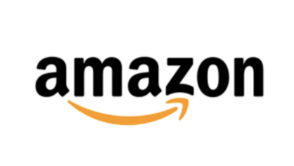

# **Impact of Discounts on Amazon Sales & Customer Analysis**

## **Background**
Amazon is one of the largest e-commerce platforms, offering a wide range of products with frequent discounts and promotions. However, despite providing significant discounts across various categories, data suggests that **higher discounts do not always result in better customer satisfaction**. Some products with bigger discounts still receive **lower ratings**, which raises important questions about:
- **Customer perception** of discounted products  
- **Product quality concerns** at higher discount rates  
- **Purchasing behavior** and its relationship with discount strategies  

Additionally, Amazon wants to **optimize its discount strategies** for high-ticket items (expensive products) to ensure that customers are satisfied with their purchases. The company also needs insights into:
- **Which product categories benefit the most from discounts**  
- **How customer feedback can improve overall sales and shopping experiences**  

This analysis will help Amazon make **data-driven decisions** to enhance customer satisfaction and maximize revenue.


## 1. Importing data

In [63]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import statsmodels.api as sm
from matplotlib.colors import LinearSegmentedColormap
import random
from wordcloud import WordCloud

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
df = pd.read_csv("/content/drive/MyDrive/MY STUDY/Dataset/amazon.csv")

## 2. Data preparation


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1465 entries, 0 to 1464
Data columns (total 16 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   product_id           1465 non-null   object
 1   product_name         1465 non-null   object
 2   category             1465 non-null   object
 3   discounted_price     1465 non-null   object
 4   actual_price         1465 non-null   object
 5   discount_percentage  1465 non-null   object
 6   rating               1465 non-null   object
 7   rating_count         1463 non-null   object
 8   about_product        1465 non-null   object
 9   user_id              1465 non-null   object
 10  user_name            1465 non-null   object
 11  review_id            1465 non-null   object
 12  review_title         1465 non-null   object
 13  review_content       1465 non-null   object
 14  img_link             1465 non-null   object
 15  product_link         1465 non-null   object
dtypes: obj

In [5]:
df_cleaned = df.dropna()
print(df_cleaned.isna().sum())

product_id             0
product_name           0
category               0
discounted_price       0
actual_price           0
discount_percentage    0
rating                 0
rating_count           0
about_product          0
user_id                0
user_name              0
review_id              0
review_title           0
review_content         0
img_link               0
product_link           0
dtype: int64


In [6]:
#Make the data consistent and more structural
df_cleaned['discounted_price'] = df_cleaned['discounted_price'].replace('[₹,]', '', regex=True).astype(float)
df_cleaned['actual_price'] = df_cleaned['actual_price'].replace('[₹,]', '', regex=True).astype(float)
df_cleaned['discount_percentage'] = df_cleaned['discount_percentage'].replace('%', '', regex=True).astype(float)
df_cleaned['rating_count'] = df_cleaned['rating_count'].replace(',', '', regex=True)
df_cleaned['rating_count'] = pd.to_numeric(df_cleaned['rating_count'], errors='coerce')
df_cleaned['rating_count'] = df_cleaned['rating_count'].astype('Int64')
df_cleaned['rating'] = pd.to_numeric(df_cleaned['rating'], errors='coerce').astype(float)

#Split the category column into lists
category_split_list = df_cleaned['category'].str.split('|')
df_cleaned['main_category'] = category_split_list.str[0]  # First category
df_cleaned['specific_category'] = category_split_list.str[-1]  # Last category

def format_category(text):
    text = re.sub(r'([a-z])([A-Z])', r'\1 \2', text)
    text = re.sub(r'([A-Z]+)([A-Z][a-z])', r'\1 \2', text)
    text = text.replace('&', ' & ')
    return text

# Apply the function to format categories
df_cleaned['main_category'] = df_cleaned['main_category'].apply(format_category)
df_cleaned['specific_category'] = df_cleaned['specific_category'].apply(format_category)


<ipython-input-6-3361009b9e3c>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned['discounted_price'] = df_cleaned['discounted_price'].replace('[₹,]', '', regex=True).astype(float)
<ipython-input-6-3361009b9e3c>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned['actual_price'] = df_cleaned['actual_price'].replace('[₹,]', '', regex=True).astype(float)
<ipython-input-6-3361009b9e3c>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc

In [7]:
df_cleaned.describe()

,discounted_price,actual_price,discount_percentage,rating,rating_count
count,1463.000000,1463.000000,1463.000000,1462.000000,1463.0
mean,3129.277122,5451.068544,47.650718,4.096717,18295.541353
std,6948.222850,10881.018448,21.622373,0.289497,42753.864952
min,39.000000,39.000000,0.000000,2.000000,2.0
25%,325.000000,800.000000,32.000000,4.000000,1186.0
50%,799.000000,1690.000000,50.000000,4.100000,5179.0
75%,1999.000000,4312.500000,63.000000,4.300000,17336.5
max,77990.000000,139900.000000,94.000000,5.000000,426973.0


## 3. Data analysis

In [8]:
zero_discount_products = df_cleaned[df_cleaned['discount_percentage'] == 0].groupby('main_category').agg({'discount_percentage': 'count', 'rating_count': 'sum'})
zero_discount_products = zero_discount_products.rename(columns={'discount_percentage': 'product_count', 'rating_count': 'total_rating_count'})
zero_discount_products['sales_per_product'] = round(zero_discount_products['total_rating_count'] / zero_discount_products['product_count'],1)

zero_discount_products

,product_count,total_rating_count,sales_per_product
main_category,,,
Computers & Accessories,8,71673,8959.1
Electronics,10,158309,15830.9
Home & Kitchen,17,154137,9066.9
Office Products,13,48775,3751.9
Toys & Games,1,15867,15867.0


In [9]:
zero_discount_products = df_cleaned[df_cleaned['discount_percentage'] == 0].groupby('main_category').agg({
    'discount_percentage': 'count','rating_count': 'sum','actual_price': 'mean'})
zero_discount_products = zero_discount_products.rename(columns={'discount_percentage': 'product_count','rating_count': 'total_rating_count','actual_price': 'average_actual_price'})
zero_discount_products['revenue'] = round(zero_discount_products['total_rating_count'] * zero_discount_products['average_actual_price'], 1)
zero_discount_products['average_revenue'] = round(zero_discount_products['revenue'] / zero_discount_products['product_count'], 1)
zero_discount_products


,product_count,total_rating_count,average_actual_price,revenue,average_revenue
main_category,,,,,
Computers & Accessories,8,71673,279.000000,19996767.0,2499595.9
Electronics,10,158309,11489.200000,1818843762.8,181884376.3
Home & Kitchen,17,154137,894.000000,137798478.0,8105792.8
Office Products,13,48775,316.846154,15454171.2,1188782.4
Toys & Games,1,15867,150.000000,2380050.0,2380050.0


In [11]:
df_cleaned_1 = df_cleaned[df_cleaned['discount_percentage'] != 0]

In [36]:
df_cleaned_1['revenue'] = df_cleaned_1['discounted_price'] * df_cleaned_1['rating_count']

<ipython-input-36-c924b0473ee0>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned_1['revenue'] = df_cleaned_1['discounted_price'] * df_cleaned_1['rating_count']


In [15]:
with_discount_products = df_cleaned_1[df_cleaned_1['discount_percentage'] != 0].groupby('main_category').agg({
    'discount_percentage': 'count', 'rating_count': 'sum', 'discounted_price': 'mean'
    }).sort_values(by='discount_percentage', ascending=False)
with_discount_products = with_discount_products.rename(columns={'discount_percentage': 'product_count', 'rating_count': 'total_rating_count','discounted_price': 'average_discounted_price'})
with_discount_products['average_revenue'] = round(((with_discount_products['total_rating_count'] * with_discount_products['average_discounted_price'])/with_discount_products['product_count']),1)
with_discount_products

,product_count,total_rating_count,average_discounted_price,average_revenue
main_category,,,,
Electronics,516,15620539,5858.846899,177361136.6
Computers & Accessories,443,7657016,855.622167,14788967.5
Home & Kitchen,431,2836932,2387.282622,15713592.7
Office Products,18,100900,290.555556,1628725.3
Home Improvement,2,8566,337.000000,1443371.0
Musical Instruments,2,88882,638.000000,28353358.0
Car & Motorbike,1,1118,2339.000000,2615002.0
Health & Personal Care,1,3663,899.000000,3293037.0


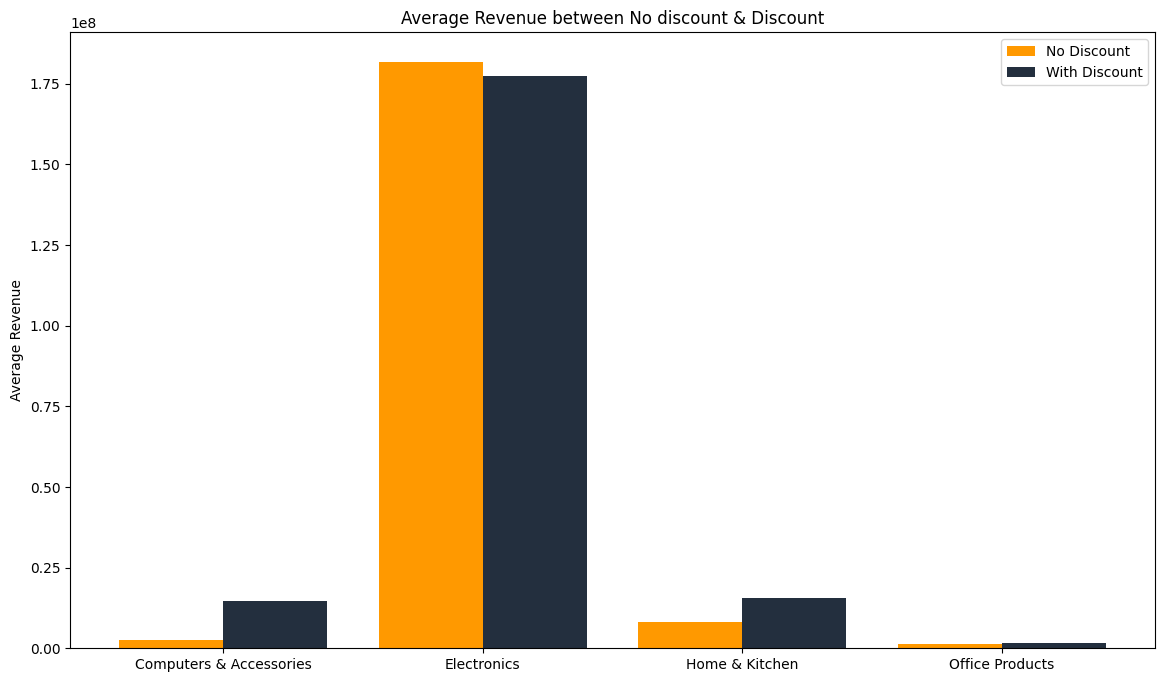

In [46]:
categories = ['Computers & Accessories', 'Electronics', 'Home & Kitchen', 'Office Products']
sales_per_product_no_discount = [2499595.9, 181884376.3, 8105792.8, 1188782.4]
sales_per_product_discount = [14788967.5, 177361136.6, 15713592.7, 1628725.3]

x = np.arange(len(categories))
fig, ax = plt.subplots(figsize=(14, 8))
width = 0.4
bar1 = ax.bar(x - width/2, sales_per_product_no_discount, width, label='No Discount', color='#ff9900')
bar2 = ax.bar(x + width/2, sales_per_product_discount, width, label='With Discount', color='#232f3e')
ax.set_ylabel('Average Revenue')
ax.set_title('Average Revenue between No discount & Discount')
ax.set_xticks(x)
ax.set_xticklabels(categories, rotation=0, ha='center')
ax.legend()

plt.show()

In [34]:
bins = [0, 20, 40, 60, 80, 100]
labels = ['0-20', '20-40', '40-60', '60-80', '80-100']
df_cleaned_1['discount_group'] = pd.cut(df_cleaned_1['discount_percentage'], bins=bins, labels=labels, right=False)

grouped_data = df_cleaned_1.groupby('discount_group').agg(
    average_discount_percentage=('discount_percentage', 'mean'),
    average_rating_count=('rating_count', 'mean'),
    average_revenue=('revenue', 'mean'),
    average_discount_price=('discounted_price', 'mean'),
    star_rating=('rating', 'mean')
)
grouped_data = grouped_data.round(2)
grouped_data

<ipython-input-34-c11fab9e4e81>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned_1['discount_group'] = pd.cut(df_cleaned_1['discount_percentage'], bins=bins, labels=labels, right=False)
<ipython-input-34-c11fab9e4e81>:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_data = df_cleaned_1.groupby('discount_group').agg(


,average_discount_percentage,average_rating_count,average_revenue,average_discount_price,star_rating
discount_group,,,,,
0-20,12.75,17261.09,83721338.02,4353.87,4.14
20-40,29.81,19541.37,118254691.22,6519.48,4.13
40-60,49.46,16175.71,27836437.57,2882.39,4.09
60-80,67.52,23258.0,18462434.16,950.93,4.06
80-100,83.69,9954.12,8713141.13,608.49,4.03


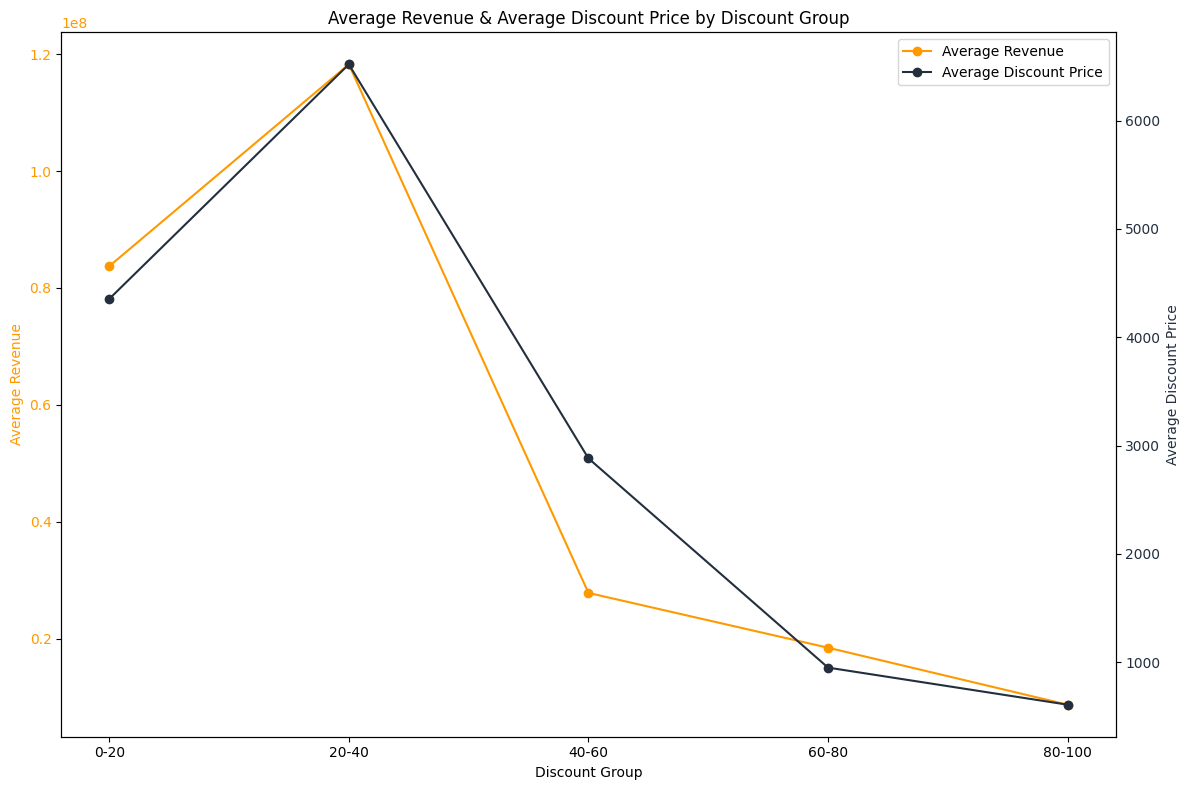

In [43]:
fig, ax1 = plt.subplots(figsize=(12, 8))
ax1.plot(grouped_data.index, grouped_data['average_revenue'], color='#ff9900', label='Average Revenue', marker='o', linestyle='-')
ax1.set_ylabel('Average Revenue', color='#ff9900')
ax1.tick_params(axis='y', labelcolor='#ff9900')
ax1.set_xlabel('Discount Group')
ax1.set_xticks(range(len(grouped_data.index)))
ax1.set_xticklabels(grouped_data.index)

ax2 = ax1.twinx()
ax2.plot(grouped_data.index, grouped_data['average_discount_price'], color='#232f3e', label='Average Discount Price', marker='o', linestyle='-')
ax2.set_ylabel('Average Discount Price', color='#232f3e')
ax2.tick_params(axis='y', labelcolor='#232f3e')

plt.title('Average Revenue & Average Discount Price by Discount Group')
fig.tight_layout()
fig.legend(['Average Revenue', 'Average Discount Price'], loc='upper right', bbox_to_anchor=(1, 1), bbox_transform=ax1.transAxes)

plt.show()

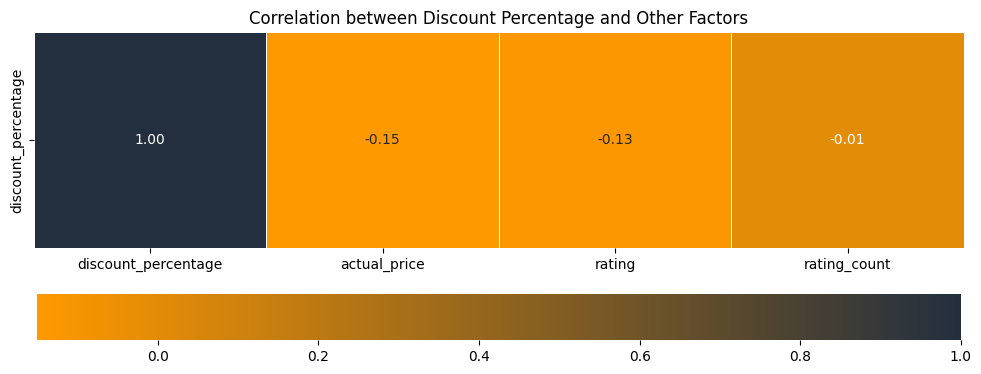

In [47]:
correlation_data = df_cleaned_1[['discount_percentage', 'actual_price', 'rating', 'rating_count']]
correlation_matrix = correlation_data.corr()

# Filter the matrix to only include rating_count correlations
rating_count_corr = correlation_matrix[['discount_percentage']].transpose()

custom_cmap = LinearSegmentedColormap.from_list("my_cmap", ["#ff9900", "#232f3e"])
plt.figure(figsize=(12, 4))
sns.heatmap(rating_count_corr, annot=True, cmap=custom_cmap, fmt=".2f", linewidths=0.5, cbar_kws={'orientation': 'horizontal'})
plt.title('Correlation between Discount Percentage and Other Factors')

plt.show()

In [42]:
category_corr = {}
for category, group in df_cleaned_1.groupby('main_category'):
    correlation = group['rating'].corr(group['discounted_price'])
    category_corr[category] = correlation

category_corr_df = pd.DataFrame.from_dict(category_corr, orient='index', columns=['Price-Rating Correlation'])
category_corr_df = category_corr_df.reset_index().rename(columns={'index': 'main_category'})

print(category_corr_df)


             main_category  Price-Rating Correlation
0          Car & Motorbike                       NaN
1  Computers & Accessories                  0.077697
2              Electronics                  0.208210
3   Health & Personal Care                       NaN
4           Home & Kitchen                  0.218079
5         Home Improvement                 -1.000000
6      Musical Instruments                  1.000000
7          Office Products                  0.078097


/usr/local/lib/python3.11/dist-packages/numpy/lib/function_base.py:2889: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
/usr/local/lib/python3.11/dist-packages/numpy/lib/function_base.py:2748: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/usr/local/lib/python3.11/dist-packages/numpy/lib/function_base.py:2748: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


<ipython-input-50-90f26f804ea2>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  electronics_df['discount_group'] = pd.cut(electronics_df['discount_percentage'], bins=bins, labels=labels, right=False)


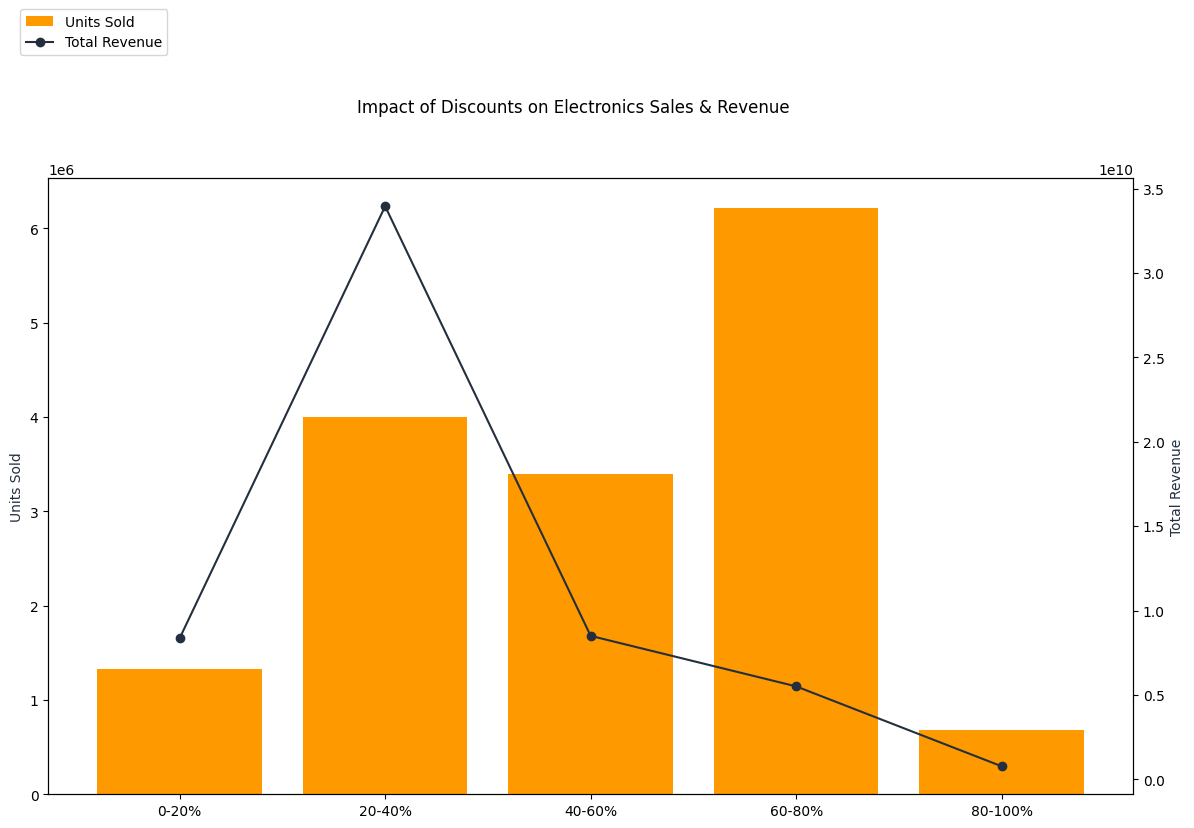

In [50]:
electronics_df = df_cleaned_1[df_cleaned_1['main_category'] == 'Electronics']

bins = [0, 20, 40, 60, 80, 100]
labels = ['0-20%', '20-40%', '40-60%', '60-80%', '80-100%']
electronics_df['discount_group'] = pd.cut(electronics_df['discount_percentage'], bins=bins, labels=labels, right=False)

grouped = electronics_df.groupby('discount_group', observed=True).agg(
    total_units_sold=('rating_count', 'sum'),
    total_revenue=('revenue', 'sum'),
    average_discount_percentage=('discount_percentage', 'mean')
).reset_index()

fig, ax1 = plt.subplots(figsize=(14, 8))
bars = ax1.bar(grouped['discount_group'], grouped['total_units_sold'], color='#ff9900', label='Units Sold')
ax1.set_ylabel('Units Sold', color='#232f3e')

ax2 = ax1.twinx()
ax2.plot(grouped['discount_group'], grouped['total_revenue'], color='#232f3e', marker='o', label='Total Revenue')
ax2.set_ylabel('Total Revenue', color='#232f3e')
fig.suptitle('Impact of Discounts on Electronics Sales & Revenue')
fig.legend(loc='upper left', bbox_to_anchor=(0.1, 1.1))
plt.grid(False)

plt.show()



<ipython-input-53-beb8fd9fd478>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned_1['category_grouped'] = df_cleaned_1['main_category'].apply(lambda x: x if x in main_categories else 'Others')


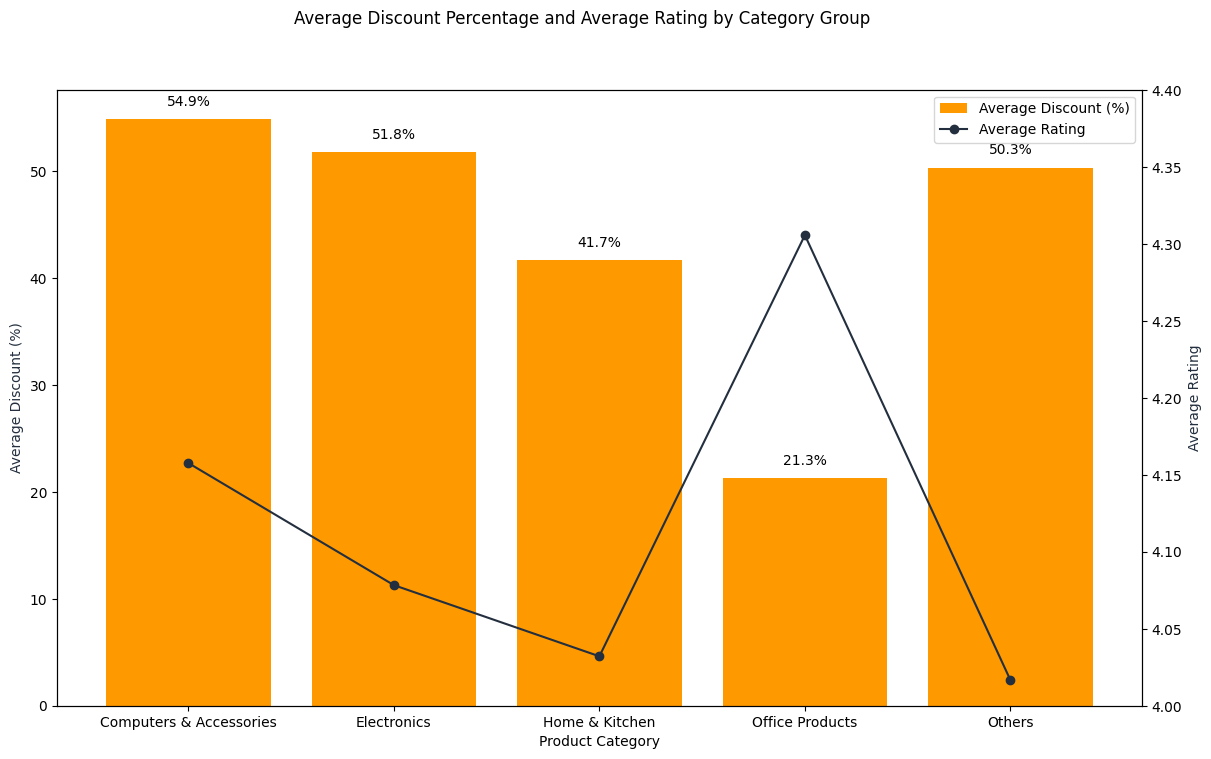

In [53]:
main_categories = ['Computers & Accessories', 'Electronics', 'Home & Kitchen', 'Office Products']
df_cleaned_1['category_grouped'] = df_cleaned_1['main_category'].apply(lambda x: x if x in main_categories else 'Others')

# Group data by the new category grouping
grouped = df_cleaned_1.groupby('category_grouped', as_index=False).agg(
    average_discount_percentage=('discount_percentage', 'mean'),
    average_rating=('rating', 'mean'))

fig, ax1 = plt.subplots(figsize=(14, 8))
categories = grouped['category_grouped']
average_discount = grouped['average_discount_percentage']
bars = ax1.bar(categories, average_discount, color='#ff9900', label='Average Discount (%)')
ax1.set_ylabel('Average Discount (%)', color='#232f3e')
ax1.set_xlabel('Product Category')

# Add data labels on top of bars
for bar in bars:
    yval = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width() / 2, yval + 1, f'{yval:.1f}%', ha='center', va='bottom', fontsize=10)

ax2 = ax1.twinx()
average_rating = grouped['average_rating']
ax2.plot(categories, average_rating, color='#232f3e', marker='o', linestyle='-', label='Average Rating')
ax2.set_ylabel('Average Rating', color='#232f3e')
ax2.set_ylim(4, 4.4)

fig.suptitle('Average Discount Percentage and Average Rating by Category Group')
fig.legend(loc='upper right', bbox_to_anchor=(1, 1), bbox_transform=ax1.transAxes)
plt.xticks(rotation=30)
plt.grid(False)

plt.show()


### **Sentimental Analysis**

In [56]:
import pandas as pd
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer
import nltk
nltk.download('all')

[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/abc.zip.
[nltk_data]    | Downloading package alpino to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/alpino.zip.
[nltk_data]    | Downloading package averaged_perceptron_tagger to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data]    | Downloading package averaged_perceptron_tagger_eng to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping
[nltk_data]    |       taggers/averaged_perceptron_tagger_eng.zip.
[nltk_data]    | Downloading package averaged_perceptron_tagger_ru to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping
[nltk_data]    |       taggers/averaged_perceptron_tagger_ru.zip.
[nltk_data]    | Downloading package averaged_perceptron_tagger_rus to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |  

True

In [57]:
df_reviews = df_cleaned_1[['review_content','rating','review_title']]

In [58]:
def preprocess_text(text):
    # Tokenize the text
    tokens = word_tokenize(text.lower())
    # Remove stop words
    filtered_tokens = [token for token in tokens if token not in stopwords.words('english')]
    # Lemmatize the tokens
    lemmatizer = WordNetLemmatizer()
    lemmatized_tokens = [lemmatizer.lemmatize(token) for token in filtered_tokens]
    # Join the tokens back into a string
    processed_text = ' '.join(lemmatized_tokens)
    return processed_text
# apply the function df
df_reviews['review_content'] = df_reviews['review_content'].apply(preprocess_text)
df_reviews['review_title'] = df_reviews['review_title'].apply(preprocess_text)

<ipython-input-58-883e887b509d>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_reviews['review_content'] = df_reviews['review_content'].apply(preprocess_text)
<ipython-input-58-883e887b509d>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_reviews['review_title'] = df_reviews['review_title'].apply(preprocess_text)


In [59]:
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('omw-1.4')

# Filter for low-rated products (rating < 3)
low_rated_df = df_reviews[df_reviews['rating'] <= 3].copy()
# Combine review_title and review_content into a single column
low_rated_df['combined_review'] = low_rated_df['review_title'] + ' ' + low_rated_df['review_content']

# Text preprocessing function
def preprocess_text(text):
    if isinstance(text, str):
      tokens = word_tokenize(text.lower())
      filtered_tokens = [token for token in tokens if token not in stopwords.words('english')]
      lemmatizer = WordNetLemmatizer()
      lemmatized_tokens = [lemmatizer.lemmatize(token) for token in filtered_tokens]
      processed_text = ' '.join(lemmatized_tokens)
      return processed_text
    else:
      return ''
low_rated_df['processed_review'] = low_rated_df['combined_review'].apply(preprocess_text)

# Word Frequency Analysis
vectorizer = CountVectorizer(max_features=50) #Adjust max_features to display more or less words
word_counts = vectorizer.fit_transform(low_rated_df['processed_review'])
word_list = vectorizer.get_feature_names_out()
word_frequency = word_counts.toarray().sum(axis=0)

# Create a DataFrame for word frequency
word_freq_df = pd.DataFrame({'word': word_list, 'frequency': word_frequency})
word_freq_df = word_freq_df.sort_values('frequency', ascending=False)

# Print most frequent words
print("Most Frequent Words in Low-Rated Reviews:")
print(word_freq_df) #Adjust number to display more or less words

# N-gram Analysis
ngram_vectorizer = CountVectorizer(ngram_range=(2, 4), max_features=50) #Adjust ngram_range and max_features accordingly
ngram_counts = ngram_vectorizer.fit_transform(low_rated_df['processed_review'])
ngram_list = ngram_vectorizer.get_feature_names_out()
ngram_frequency = ngram_counts.toarray().sum(axis=0)

# Create a DataFrame for n-gram frequency
ngram_freq_df = pd.DataFrame({'ngram': ngram_list, 'frequency': ngram_frequency})
ngram_freq_df = ngram_freq_df.sort_values('frequency', ascending=False)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


Most Frequent Words in Low-Rated Reviews:
             word  frequency
32        product         44
14           good         28
48        working         16
3         battery          9
47           work          9
19          money          9
34        quality          8
46          water          8
8             day          8
40           time          7
42            use          6
38           seal          6
21             ok          6
20           nice          6
33       properly          6
13            get          6
11          first          6
5             buy          6
2             bad          6
18           like          5
45          waste          5
9            easy          5
22            one          5
37    replacement          5
27           poor          5
0          amazon          5
41         update          4
44         useful          4
39        sealing          4
36         remote          4
35         rating          4
49          worth          4
1

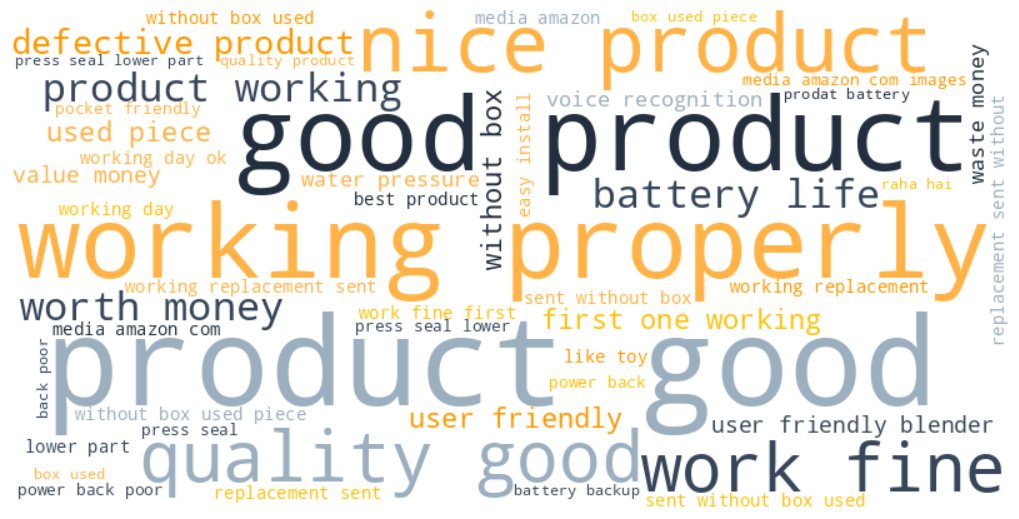

In [64]:
# Custom color function to use Amazon orange and dark blue
def custom_color_func(word, font_size, position, orientation, random_state=None, **kwargs):
    colors = ['#232F3E', '#FFB347', '#37475A', '#9BAFBF', '#FFC107', '#FF9900']  # Amazon orange and dark blue
    return random.choice(colors)

# Create word frequency dictionary
phrases_freq_dict = dict(zip(ngram_freq_df['ngram'], ngram_freq_df['frequency']))

# Generate the word cloud with custom color function
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(phrases_freq_dict)

# Recolor the word cloud using the custom color function
wordcloud.recolor(color_func=custom_color_func)

plt.figure(figsize=(10, 7), facecolor=None)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()
